# Filtrando ruído com autoencoder

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
#K.set_image_data_format("channels_first")
K.set_image_data_format("channels_last")

from keras.datasets import mnist

import sys,os
sys.path.append("../src")
from my_keras_utilities import TrainingPlotter

Using TensorFlow backend.


In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [4]:
print(x_train_noisy.shape)
print(x_test_noisy.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


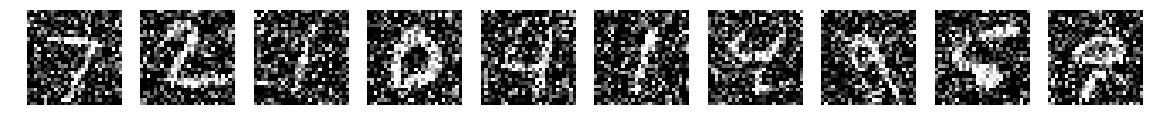

In [5]:
n = 10
plt.figure(figsize=(20, 2))
plt.gray()
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.axis('off')
plt.show()

## Rede autoencoder

In [8]:
input_img = Input(shape=(None, None, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img,decoded)

## Sumário da rede

In [9]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, None, None, 32)    0         
__________

## Poucas amostras para teste inicial

In [10]:
testing = True
if testing:
    n_samples = 100
    x_train = x_train[:n_samples]
    x_train_noisy = x_train_noisy[:n_samples]
    
    n_samples_test = 100
    x_test = x_test[:n_samples_test]
    x_test_noisy = x_test_noisy[:n_samples]

## Treinamento

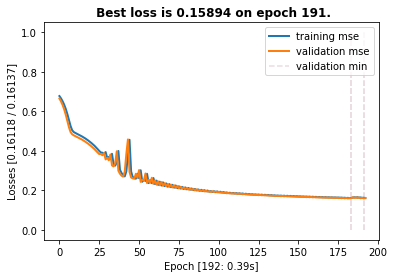

In [11]:
model_path = '../../models/'
model_name = 'autoencoder2_noisy'
model_file = model_path + model_name

sys.path.append("../src")
from my_keras_utilities import TrainingPlotter, load_model_and_history

if not os.path.isfile(model_file + '.model'):
    print("[INFO] creating model...",model_file)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mse')
    my_big_callback = TrainingPlotter(n=1, patience=15, filepath=model_file)
    fig = plt.figure(figsize=(15,6))
    plt.grid(True)
else:
    print("[INFO] loading model...",model_file)
    autoencoder, my_big_callback = load_model_and_history(model_file)

#past_epochs = my_big_callback.get_nepochs()

try:
    autoencoder.fit(x_train_noisy[:128], x_train[:128],
                epochs=100,
                batch_size=128,
                shuffle=True,
                verbose = 0,    
                validation_data=(x_test_noisy[:128], x_test[:128]),
                callbacks=[my_big_callback])
except KeyboardInterrupt:
    pass

In [12]:
if False:
    os.makedirs('../../models', exist_ok=True)
    autoencoder.save(filepath= model_file + '.model')

## Testando 10 primeiras amostras de teste

In [13]:
y_hat = autoencoder.predict(x_test_noisy[:10],batch_size=10)
print(y_hat.shape)

(10, 28, 28, 1)


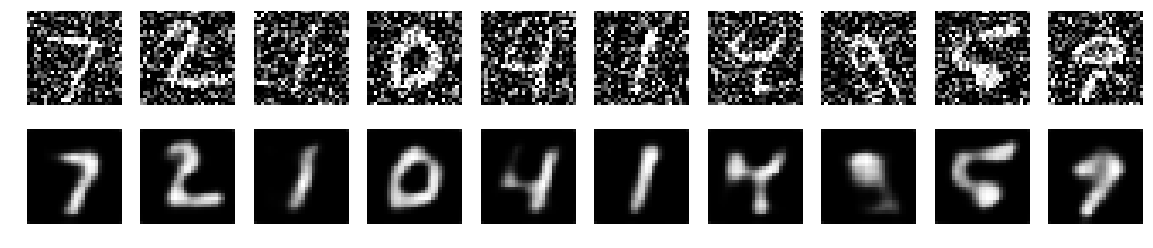

In [14]:
n = 10
fig = plt.figure(figsize=(20, 4))
plt.gray()
#fig,ax = plt.subplots(2,10)
for i in range(n):
    ax = fig.add_subplot(2, 10, i+1)
    ax.imshow(x_test_noisy[i].reshape(28, 28))
    ax.axis('off')
for i in range(n):
    ax = fig.add_subplot(2, 10, i+11)
    ax.imshow(y_hat[i].reshape(28, 28))
    ax.axis('off')
plt.show();

## Testando com imagem de tamanho maior

Como a rede é formada de camadas convolucionais, é possível que a imagem de entrada tenha qualquer tamanho.
Veja o exemplo a seguir, onde 4 imagens são juntadas para formar uma de shape=(56,56).

(1, 56, 56, 1)


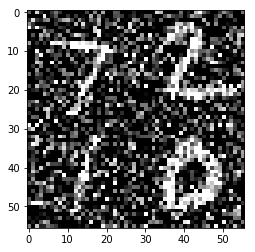

In [18]:
img1 = np.hstack([x_test_noisy[0],x_test_noisy[1]])
img2 = np.hstack([x_test_noisy[2],x_test_noisy[3]])
img = np.vstack([img1,img2]).reshape(1,56,56,1)
print(img.shape)
plt.imshow(img.reshape(56,56),cmap='gray')
                 

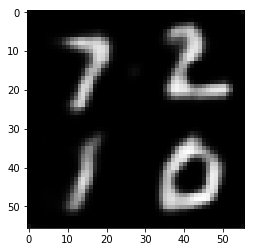

In [16]:
yy_hat = autoencoder.predict(img,batch_size=1)
plt.imshow(yy_hat.reshape(56,56),cmap='gray');

## Aprendizados